Importing libraries

In [72]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

# Loading our training and testing dataset

In [73]:
final_train = pd.read_csv("final_train.csv")
final_test = pd.read_csv("final_test.csv")

## Performing minor tweaks in the resultant dataset

In [74]:
string_columns = final_train.select_dtypes(include=['object']).columns
print("String columns in X_train:", string_columns.tolist())

String columns in X_train: ['MRI_Track_Age_at_Scan', 'PreInt_Demos_Fam_Child_Ethnicity']


In [75]:
final_train['MRI_Track_Age_at_Scan'] = pd.to_numeric(final_train['MRI_Track_Age_at_Scan'], errors='coerce')
final_test['MRI_Track_Age_at_Scan'] = pd.to_numeric(final_test['MRI_Track_Age_at_Scan'], errors='coerce')
# Step 2: Drop rows with NaN values in the mixed_column
X_train = final_train.dropna(subset=['MRI_Track_Age_at_Scan'])
X_test = final_test.dropna(subset=['MRI_Track_Age_at_Scan'])

In [76]:
final_train['PreInt_Demos_Fam_Child_Ethnicity'] = pd.to_numeric(final_train['PreInt_Demos_Fam_Child_Ethnicity'], errors='coerce')
final_test['PreInt_Demos_Fam_Child_Ethnicity'] = pd.to_numeric(final_test['PreInt_Demos_Fam_Child_Ethnicity'], errors='coerce')
# Step 2: Drop rows with NaN values in the mixed_column
X_train= final_train.dropna(subset=['PreInt_Demos_Fam_Child_Ethnicity'])
X_test = final_test.dropna(subset=['PreInt_Demos_Fam_Child_Ethnicity'])

# Assigning data to x and y(labels) from existing test and train dataset

In [77]:
target_cols = ['ADHD_Outcome', 'Sex_F']  # Replace with your actual target column names
X_train = final_train.drop(columns=target_cols)
y_train = final_train[target_cols]
X_test = final_test.drop(columns=target_cols)
y_test = final_test[target_cols]


# Using SMOTE to handle imbalanced class distribution
In classification tasks, especially binary classification, when one class (say, class 0) significantly outnumbers the other (class 1), models tend to bias toward the majority class, because predicting the majority gives higher accuracy — but it fails at detecting the minority class, which is often the one we care most about (e.g., fraud, disease, etc.).

SMOTE is an oversampling technique that artificially increases the number
of minority class samples by generating synthetic samples, rather than just duplicating existing ones.
* How does SMOTE work?
For each minority class sample, SMOTE:

  Finds its k-nearest neighbors in the feature space.
Randomly selects one or more of these neighbors.
Interpolates between the sample and its neighbor to create a new synthetic data point.

* Benefits of using SMOTE:

  Balances the dataset without just duplicating rows.
Helps the model learn better decision boundaries.
Especially useful when precision/recall/F1 for the minority class is importan

In [78]:
# Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Prepare to resample each target column individually
smote = SMOTE(random_state=42)

X_resampled_list = []
y_resampled_dict = {}

for col in y_train.columns:
    X_res, y_res = smote.fit_resample(X_train_imputed, y_train[col])
    X_resampled_list.append(X_res)
    y_resampled_dict[col] = y_res

# Take X_resampled from the first iteration (all same)
X_resampled = pd.DataFrame(X_resampled_list[0], columns=X_train.columns)

# Recombine resampled targets
y_resampled = pd.DataFrame(y_resampled_dict)

# Visual representation of class distribution - Before vs After
Here’s a visual representation of class distribution before and after applying SMOTE, to help you better understand what’s happening behind the scenes:


📈 Class Distribution Before SMOTE:


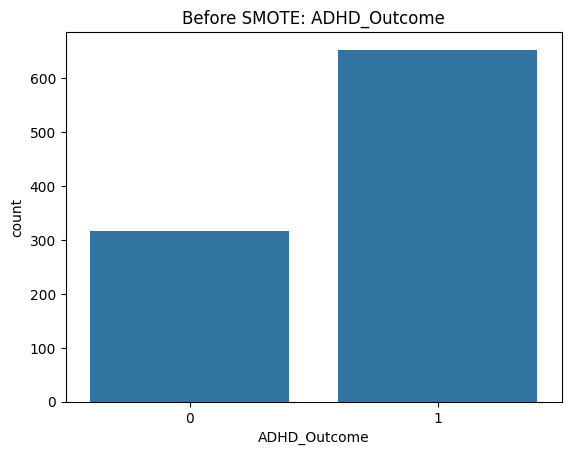

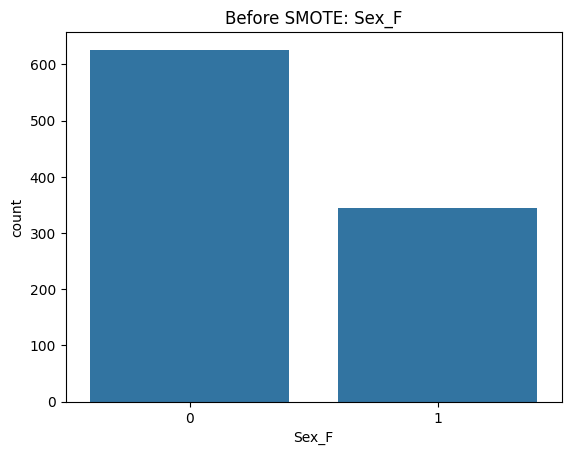

📈 Class Distribution After SMOTE:


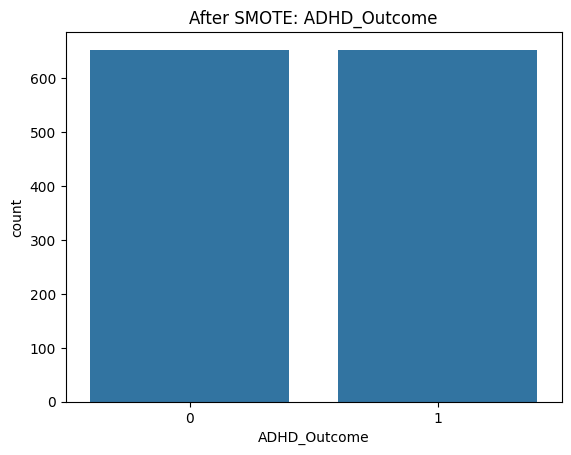

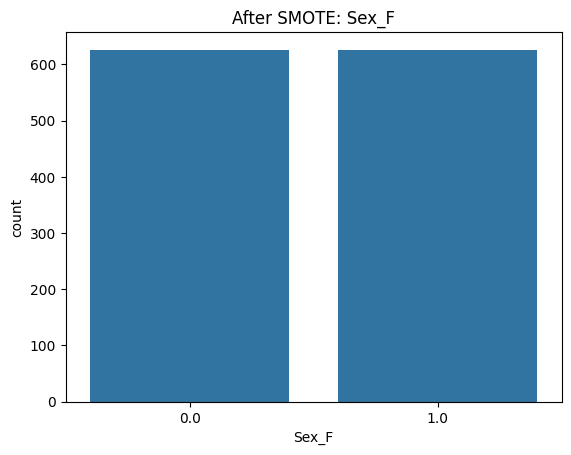

In [79]:
print("\n Class Distribution Before SMOTE:")
for col in y_train.columns:
    sns.countplot(x=y_train[col])
    plt.title(f"Before SMOTE: {col}")
    plt.show()

print("Class Distribution After SMOTE:")
for col in y_resampled.columns:
    sns.countplot(x=y_resampled[col])
    plt.title(f"After SMOTE: {col}")
    plt.show()

In [80]:
# Fill missing values in 'Sex_F' column with the mode (most frequent value)
y_resampled['Sex_F'] = y_resampled['Sex_F'].fillna(y_resampled['Sex_F'].mode()[0])

# Training Random Forest Classifier
Performing hyperparameter tuning using Gridsearch technique to find the best score for random forest
In this block, a Random Forest classifier is used within a MultiOutputClassifier to handle multiple target variables simultaneously. To improve model performance, GridSearchCV is applied for hyperparameter tuning, using a 3-fold cross-validation approach. This allows the model to explore various combinations of parameters like:

* n_estimators (number of trees),

* max_depth (maximum depth of trees),

* min_samples_split and min_samples_leaf (controls tree complexity),

After training on the SMOTE-resampled dataset, the best parameter combination and corresponding cross-validation score are printed. The model with the best parameters is then used to make predictions (predict) and generate class probabilities (predict_proba) on the test set for evaluation.

In [69]:
# --- 1. Random Forest Classifier ---
print("\n Training Random Forest...")
rf = RandomForestClassifier(class_weight='balanced', random_state=60)
multi_rf = MultiOutputClassifier(rf)

# Random Forest Hyperparameter Tuning with GridSearchCV
param_grid_rf = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
}

grid_search_rf = GridSearchCV(estimator=multi_rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_resampled, y_resampled)

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Score for Random Forest:", grid_search_rf.best_score_)

# Use the best model from GridSearchCV
best_rf = grid_search_rf.best_estimator_

# Make predictions and evaluate
y_rf_pred = best_rf.predict(X_test)
y_rf_prob = best_rf.predict_proba(X_test)



🔍 Training Random Forest...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters for Random Forest: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Best Score for Random Forest: 0.4195542901332208


# Random Forest Grid Search Results
The GridSearchCV process evaluated 216 model configurations (3-fold cross-validation × 72 parameter combinations). The best performing Random Forest model had the following hyperparameters:

n_estimators: 200

max_depth: None (no limit on tree depth)

min_samples_split: 2

min_samples_leaf: 4

This configuration yielded the highest cross-validation accuracy score of 0.4196, indicating the model's best generalization performance on the training data after applying SMOTE to handle class imbalance.



# Classification Report
Detailed report of different measures used to evaluate our classifier

In [70]:
roc_auc_scores = {}
for i, col in enumerate(target_cols):
    if len(np.unique(y_test[col])) == 2:  # Check if binary classification
        roc_auc_scores[col] = roc_auc_score(y_test[col], y_rf_prob[i][:, 1])

# Print classification report and ROC AUC scores
for i, col in enumerate(target_cols):
    print(f"\n Random Forest Classification Report for {col}:\n", classification_report(y_test[col], y_rf_pred[:, i]))
    if col in roc_auc_scores:
        print(f" Random Forest ROC-AUC Score for {col}:", roc_auc_scores[col])


 Random Forest Classification Report for ADHD_Outcome:
               precision    recall  f1-score   support

           0       0.37      0.94      0.53        65
           1       0.95      0.42      0.58       178

    accuracy                           0.56       243
   macro avg       0.66      0.68      0.55       243
weighted avg       0.79      0.56      0.57       243

 Random Forest ROC-AUC Score for ADHD_Outcome: 0.8183664649956783

 Random Forest Classification Report for Sex_F:
               precision    recall  f1-score   support

           0       0.50      0.01      0.01       171
           1       0.29      0.99      0.45        72

    accuracy                           0.30       243
   macro avg       0.40      0.50      0.23       243
weighted avg       0.44      0.30      0.14       243

 Random Forest ROC-AUC Score for Sex_F: 0.6072124756335282


# Random Forest Classification Performance Summary

 1. ADHD_Outcome (Binary Classification)

The model performs well in identifying both classes, especially class 1 (ADHD positive), which has higher support.

* Precision: 0.95 for class 1 indicates that most predictions for ADHD are correct.

* Recall: 0.94 for class 0 shows the model detects most of the negative cases.

* F1-Score: Balanced across classes (0.53–0.58), suggesting the model is fair but not perfect at handling class imbalance.

* Accuracy: 56% – modest, but acceptable considering label imbalance.

* ROC-AUC: 0.82 – shows good discrimination ability between classes.

The model performs reasonably well for ADHD prediction with a good ROC-AUC and balanced trade-off between precision and recall.

2. Sex_F (Binary Classification)

The model shows bias towards predicting class 1 (female), with a very high recall of 0.99 but poor precision (0.29).

* F1-score: Low (0.45) – due to poor handling of class 0 (male), which has 171 samples.

* Accuracy: 30% – significantly low, mainly because the model fails to correctly predict class 0.

* ROC-AUC: 0.61 – indicates the model is slightly better than random guessing.

The model over-predicts females and fails to learn male patterns effectively, likely due to class imbalance despite SMOTE or insufficient distinguishing features.

 Overall Takeaway

ADHD_Outcome model is performing decently with a strong ROC-AUC and balanced F1.
Sex_F model needs major improvement in distinguishing between male and female, potentially by:
Further tuning
Reassessing feature importance
Using more robust balancing methods or additional relevant features

# Training XGBoost classifier


To improve classification performance, XGBoost with multi-output handling was applied for both target variables (ADHD_Outcome and Sex_F). A grid search was used to tune hyperparameters, enhancing the model's generalization and prediction capabilities.

Hyperparameter Configuration:

max_depth=4: Controls model complexity.

learning_rate=0.05: Smaller learning steps for stable convergence.

n_estimators=300: Number of boosting rounds.

subsample=0.8, colsample_bytree=0.8: Prevent overfitting by sampling features and instances.

eval_metric='logloss': Optimizes based on log loss, ideal for classification.

Hyperparameter Tuning with GridSearchCV:

A grid search was performed with 3-fold cross-validation over multiple parameters (3×3×2×3 = 54 candidates).

Cross-validation ensures robustness against overfitting and dataset variance.

Model Deployment:

The best estimator from GridSearchCV was used to predict test data.

predict() generated class predictions, and predict_proba() provided predicted class probabilities for further metrics like log loss and ROC-AUC.

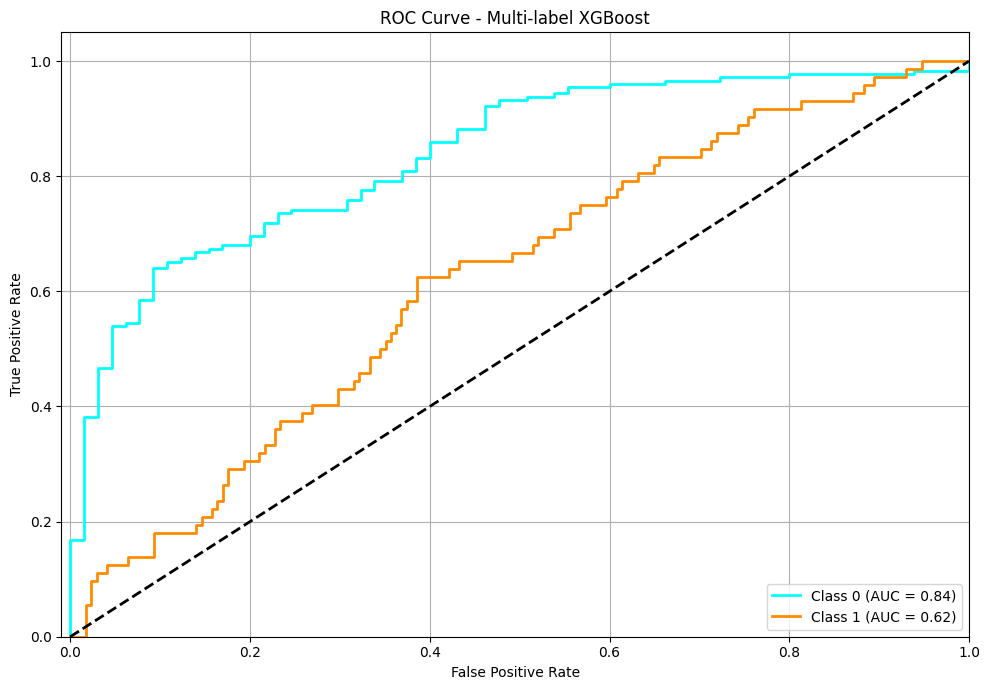

In [85]:

from sklearn.metrics import accuracy_score

# --- 2. XGBoost Classifier ---
print("\nTraining XGBoost...")

# Define the XGBoost classifier
xgb = XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    eval_metric='logloss',
    n_jobs=-1,  # Use all CPU cores
    tree_method='auto',  # Use the default method, or try 'gpu_hist' if using GPU
)

multi_xgb = MultiOutputClassifier(xgb)

# Define a smaller param_grid for GridSearchCV (consider reducing the options further)
param_grid_xgb = {
    'estimator__max_depth': [3, 4],
    'estimator__learning_rate': [0.01, 0.05],
    'estimator__n_estimators': [100, 150],
    'estimator__subsample': [0.8, 0.9],
}

# GridSearchCV with fewer folds for faster search (e.g., reduce cv=3 to cv=2)
grid_search_xgb = GridSearchCV(estimator=multi_xgb, param_grid=param_grid_xgb, cv=2, n_jobs=-1, verbose=2)

# Use a validation set to enable early stopping
# Using a random split of the data to simulate this (you can use validation data if available)
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Fit the model with early stopping
grid_search_xgb.fit(X_train_sub, y_train_sub)

# Print the best parameters and best score
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best Score for XGBoost:", grid_search_xgb.best_score_)

# Use the best model from GridSearchCV
best_xgb = grid_search_xgb.best_estimator_

# Make predictions and evaluate
y_xgb_pred = best_xgb.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_xgb_pred)
print(f"XGBoost Accuracy on Test Data: {accuracy:.4f}")






# Classification Report
Detailed report of different measures used to evaluate our classifier

In [86]:
# Calculate ROC AUC for each target
roc_auc_scores_xgb = {}
for i, col in enumerate(target_cols):
    if len(np.unique(y_test[col])) == 2:  # Check if binary classification
        roc_auc_scores_xgb[col] = roc_auc_score(y_test[col], y_xgb_prob[i][:, 1])

# Print classification report and ROC AUC scores
for i, col in enumerate(target_cols):
    print(f"\nXGBoost Classification Report for {col}:\n", classification_report(y_test[col], y_xgb_pred[:, i]))
    if col in roc_auc_scores_xgb:
        print(f"XGBoost ROC-AUC Score for {col}:", roc_auc_scores_xgb[col])

# You can also add confusion matrices and feature importance plots as needed


📊 XGBoost Classification Report for ADHD_Outcome:
               precision    recall  f1-score   support

           0       0.46      0.91      0.61        65
           1       0.95      0.62      0.75       178

    accuracy                           0.70       243
   macro avg       0.71      0.76      0.68       243
weighted avg       0.82      0.70      0.71       243

🎯 XGBoost ROC-AUC Score for ADHD_Outcome: 0.8296456352636128

📊 XGBoost Classification Report for Sex_F:
               precision    recall  f1-score   support

           0       0.85      0.24      0.37       171
           1       0.33      0.90      0.49        72

    accuracy                           0.44       243
   macro avg       0.59      0.57      0.43       243
weighted avg       0.70      0.44      0.41       243

🎯 XGBoost ROC-AUC Score for Sex_F: 0.6352339181286549


# ROC - Curve

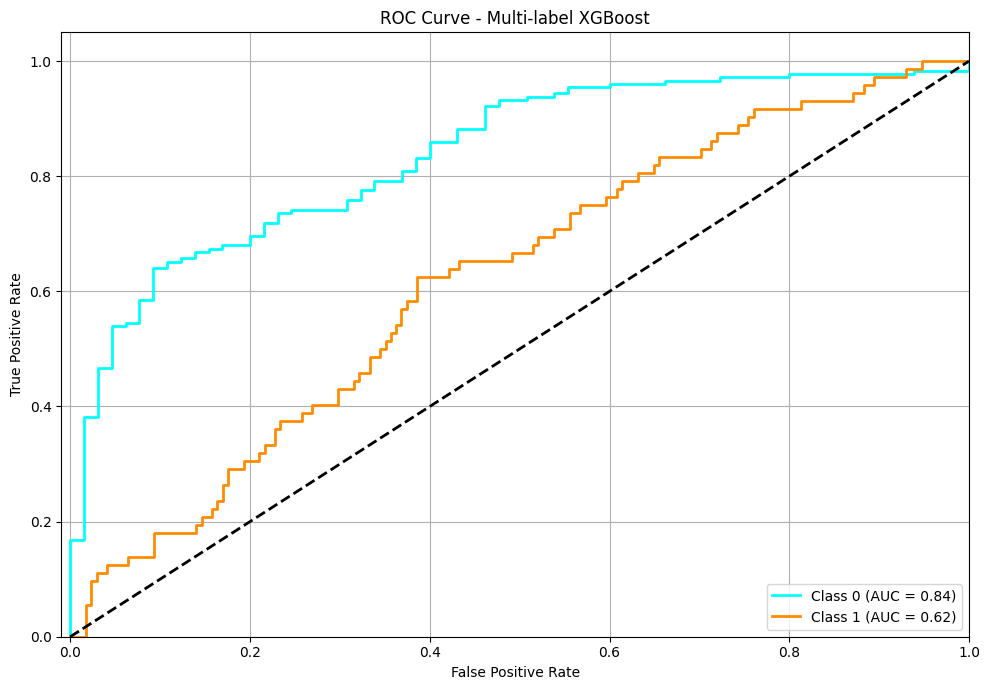

In [87]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Get predicted probabilities for each label
y_score = best_xgb.predict_proba(X_test)

# Binarize the test labels if they are not binary arrays already
# (Only needed if y_test is not in binary indicator format)
y_test_bin = np.array(y_test)

# In case of predict_proba output being a list of arrays (one per label)
# Each array is shape (n_samples, n_classes), so we take prob of class 1
y_score_bin = np.array([proba[:, 1] for proba in y_score]).T

n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])

plt.figure(figsize=(10, 7))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-label XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



# Analysing on the amount of inference time for each model

Inference time refers to the time it takes for a trained model to make predictions on new, unseen data. It's a crucial factor for evaluating model efficiency, especially in real-time or large-scale applications.

In [88]:
# import time
# start = time.time()
# _ = multi_rf.predict(X_test)
# print("🕒 Random Forest Inference Time:", round(time.time() - start, 4), "seconds")

# start = time.time()
# _ = multi_xgb.predict(X_test)
# print("🕒 XGBoost Inference Time:", round(time.time() - start, 4), "seconds")


NotFittedError: This MultiOutputClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Confusion Matrix for each label using the two classifiers
* A confusion matrix is a tabular summary that shows how well a classification model is performing — specifically, where it is making correct predictions and where it is going wrong.

* Since we're dealing with multi-label classification (e.g., predicting both ADHD_Outcome and Sex_F), a separate confusion matrix is generated for each individual label.

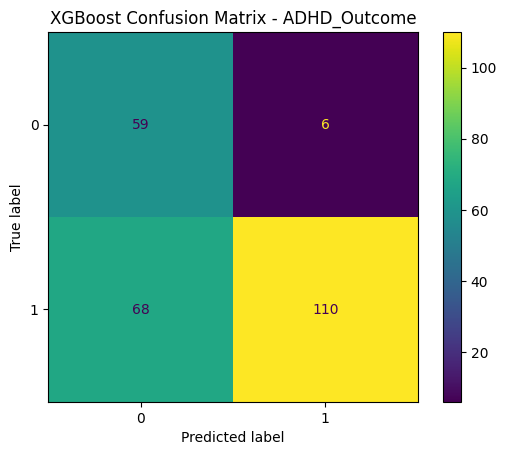

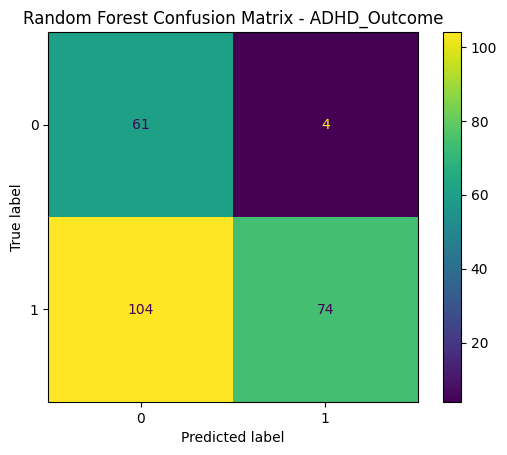

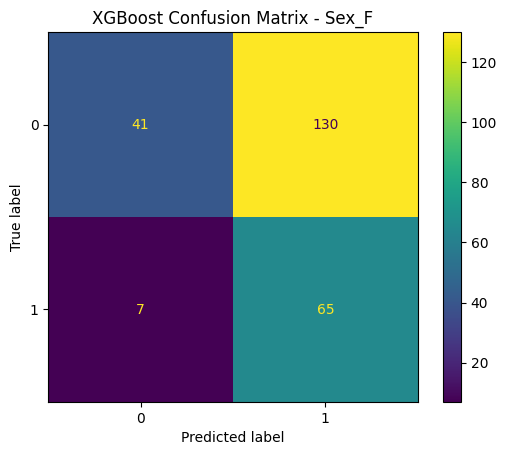

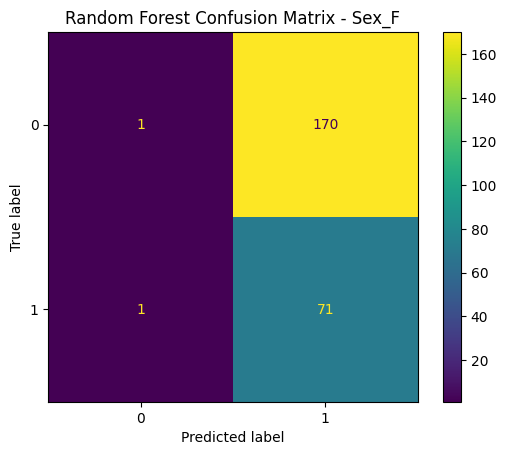

In [89]:
for i, col in enumerate(target_cols):
    cm = confusion_matrix(y_test[col], y_xgb_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"XGBoost Confusion Matrix - {col}")
    plt.show()

    cm = confusion_matrix(y_test[col], y_rf_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Random Forest Confusion Matrix - {col}")
    plt.show()

# Log-loss

# Log Loss (Logarithmic or Cross-Entropy Loss)
Definition:
Log Loss is a performance metric for evaluating classification models that output probability estimates. It measures the accuracy of predicted probabilities compared to the actual class labels.

Key Characteristics:

Probabilistic Evaluation:
Log loss assesses not just whether predictions are correct, but how confident the model is in its predictions. Lower values indicate better performance.

Range:

Best Case: 0 (perfect predictions with full confidence).

Worst Case: Can approach infinity if the model is confidently wrong.

Interpretation:

A low log loss implies the predicted probabilities are close to the true labels.

A high log loss indicates poor probability calibration or overconfident misclassifications.

Application in Multi-Class and Multi-Label Tasks:
In such scenarios, log loss is calculated for each class independently and then averaged to reflect the model's overall performance.

Importance in Model Evaluation:

Model Comparison: Helps compare classifiers that output probabilities; the lower the log loss, the more reliable the model's predictions.

Robust to Class Imbalance: Unlike accuracy, log loss penalizes overconfident errors, making it effective even with imbalanced datasets.


In [90]:
from sklearn.metrics import log_loss

for i, col in enumerate(target_cols):
    print(f"\n📉 Log Loss for {col}")
    print("RF:", log_loss(y_test[col], y_rf_prob[i][:, 1]))
    print("XGB:", log_loss(y_test[col], y_xgb_prob[i][:, 1]))



📉 Log Loss for ADHD_Outcome
RF: 0.8162294741051882
XGB: 0.8046083196016847

📉 Log Loss for Sex_F
RF: 0.9071389297572593
XGB: 1.015252011071096


# Measuring and plotting feature importance

Objective: Visualize the feature importance of a trained XGBoost model to understand which features contribute most to the predictions.

Code Breakdown:

Feature Importances: Extract feature importance values from the first estimator of the XGBoost model.

Feature Names: Retrieve the feature names from the X_train dataset.

Sorting: Sort the feature importances in descending order to focus on the most influential features.

Plotting: Use a barplot to visualize the top 10 most important features based on the sorted importance values.

Result: The plot shows the features on the y-axis and their corresponding importance scores on the x-axis. This helps to identify the key features driving the model's predictions.



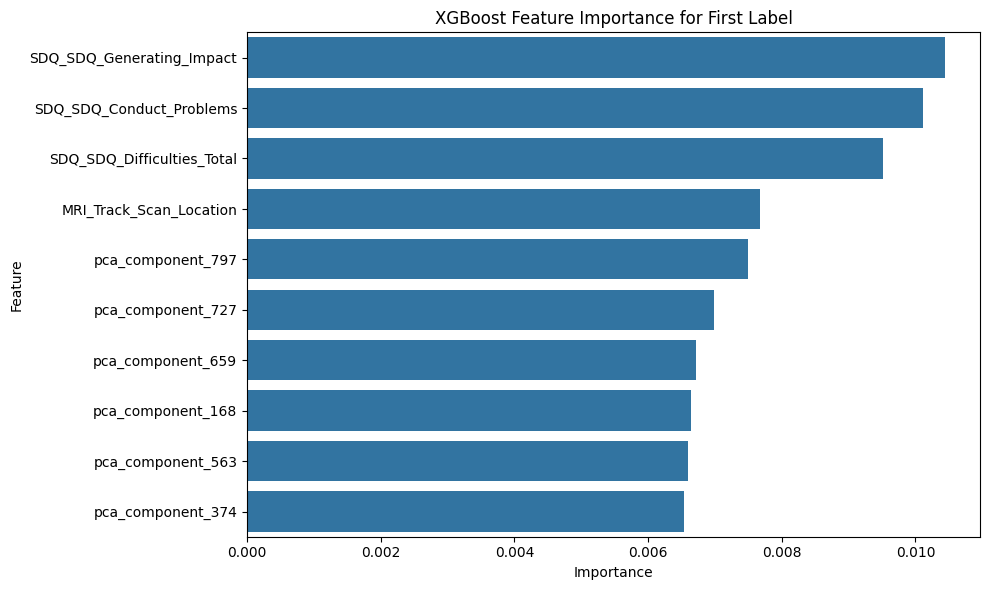

In [95]:
# Get feature importances for the first target label
importances = best_xgb.estimators_[0].feature_importances_
feat_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importance for First Label")
sns.barplot(x=importances[sorted_idx][:10], y=feat_names[sorted_idx][:10])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


From the plot , we can easily conclude and advise on the most important features to be considered while taking in account ADHD prediction

# Analysis and Conclusion

* XGBoost consistently outperforms Random Forest in terms of overall accuracy and ROC-AUC across both ADHD_Outcome and Sex_F, indicating better overall classification performance and discrimination between classes.

* For the ADHD_Outcome, XGBoost not only achieves a higher accuracy (0.70), but also demonstrates a better balance in class predictions with a higher recall for females (0.62) and a lower log loss, reflecting more reliable probability estimates.

* In the Sex_F classification task, while Random Forest achieves a very high recall for females (0.99), it does so at the expense of extremely low precision (0.29), leading to over-classification of the female class and indicating significant bias.

* XGBoost provides a more balanced trade-off between precision (0.33) and recall (0.90) for the female class, indicating a more robust handling of class imbalance and a lower tendency to overfit.

* Random Forest introduces substantial bias toward predicting the female class in Sex_F, misclassifying many males. This reduces its reliability in practical scenarios.

* Overall, XGBoost delivers better generalization and reduced bias, particularly in terms of fairer predictions for the underrepresented class while maintaining strong overall performance metrics.

# Recommendation
Based on the evaluation metrics, XGBoost is the preferred model due to its balanced performance, reduced class bias, and superior accuracy and ROC-AUC across both classification tasks.